In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import geopandas as gpd
import json
import warnings
import time
from os import listdir
from os.path import isfile,join
import datetime
from branca.element import MacroElement
from matplotlib.colors import rgb2hex
from jinja2 import Template
import folium
from branca.colormap import LinearColormap
import matplotlib
import matplotlib.ticker as ticker
import requests
from sklearn.metrics import r2_score
import catboost

In [2]:
def get_covid_data(info='cases'):
    if info == 'cases':
        url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
               'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv').format(sep=2*'\n')
        ren_col = 'Total_cases'
        val_col = 'Daily_cases'
    if info =='deaths':
            url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                    'csse_covid_19_time_series/time_series_covid19_deaths_US.csv').format(sep=2*'\n')
            ren_col = 'Total_deaths'
            val_col = 'Daily_deaths'
    df = pd.read_csv(url)
    df = df[df['iso3']=='USA']
    df = df.dropna(subset = ['FIPS'])
    df = df[df.FIPS <= 56045]

    df.FIPS = df.FIPS.astype(int).astype(str).str.zfill(5)
    df = df[(df.Admin2 != 'Unassigned' ) & (df.Admin2.notna() )]
    df = df.drop(columns= ['UID','iso2', 'iso3', 'code3','Country_Region','Combined_Key' ])
    date_cols = [col for col in df.columns if '/20' in col]
    id_cols = [col for col in df.columns if col not in date_cols]
    df_gr = df.melt(id_vars=id_cols,value_vars=date_cols)
    df_gr[val_col] = df_gr.groupby(['FIPS'])[['value']].diff().fillna(0)
    df_gr = df_gr.rename(columns = {'value':ren_col, 'variable':'date', 
                                    'Long_':'Lng', 'Admin2':'COUNTY', 
                                   'Province_State': 'STATE', 'FIPS':'fips'})
    df_gr.date = pd.to_datetime( df_gr.date, infer_datetime_format=True)
    df_gr = df_gr.drop(columns = ['STATE', 'COUNTY'])
    return df_gr
    

In [3]:
df_covid_cases = get_covid_data(info='cases')
df_covid_deaths = get_covid_data(info='deaths')[['fips','date','Total_deaths','Daily_deaths']]
df_covid = pd.merge(left = df_covid_cases, right = df_covid_deaths, on = ['fips', 'date'])
df_covid

,fips,Lat,Lng,date,Total_cases,Daily_cases,Total_deaths,Daily_deaths
0,01001,32.539527,-86.644082,2020-01-22,0,0.0,0,0.0
1,01003,30.727750,-87.722071,2020-01-22,0,0.0,0,0.0
2,01005,31.868263,-85.387129,2020-01-22,0,0.0,0,0.0
3,01007,32.996421,-87.125115,2020-01-22,0,0.0,0,0.0
4,01009,33.982109,-86.567906,2020-01-22,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
600117,56037,41.659439,-108.882788,2020-07-30,237,3.0,0,0.0
600118,56039,43.935225,-110.589080,2020-07-30,331,13.0,0,0.0
600119,56041,41.287818,-110.547578,2020-07-30,247,2.0,0,0.0
600120,56043,43.904516,-107.680187,2020-07-30,46,1.0,0,0.0


In [4]:
def get_mobility_data(rolling_mean=False):
    mob_index_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
    
    df_mobility_index = pd.read_csv(mob_index_url, parse_dates=['date'])
    df_mobility_index = df_mobility_index.dropna(subset=['fips','admin2'])
    df_mobility_index.fips = df_mobility_index.fips.astype(int)
    df_mobility_index.fips = df_mobility_index.fips.astype(str).str.zfill(5)
    df_mobility_index = df_mobility_index.rename(columns={'admin1':'STATE','admin2':'COUNTY' })
    df_mobility_index = df_mobility_index.drop(columns = ['country_code', 'admin_level'])
    df_mobility_index['weekday'] = df_mobility_index.date.dt.day_name()
    df_mobility_index = df_mobility_index[df_mobility_index.m50<200]
    if rolling_mean:
        mob_col= ['m50']
        m50 = df_mobility_index.groupby(['fips','date'])[mob_col].mean()
        m50['rolling_mean_mob'] = m50[mob_col].rolling(7,min_periods=1).mean()
        m50 = m50.reset_index()
        return m50
    
    return df_mobility_index

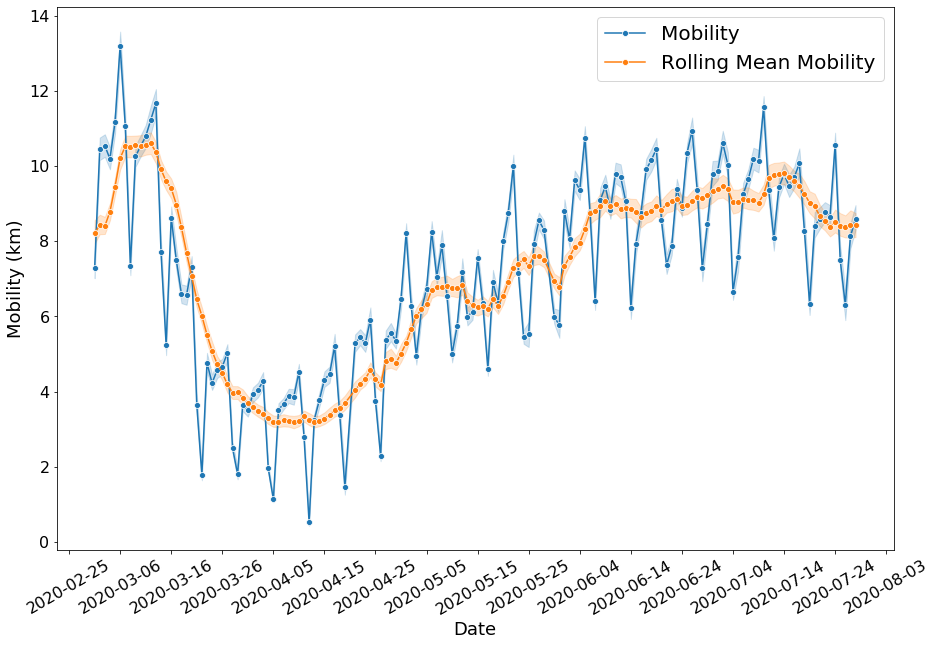

In [5]:
df_mobility = get_mobility_data()
df_mobility_rm = get_mobility_data(rolling_mean=True)
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y = 'm50', data=df_mobility, marker='o',ci=99,label = 'Mobility')
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='o',ci=99, label = 'Rolling Mean Mobility')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Mobility (km)', fontsize = 18)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=16)
plt.legend(fontsize = 20)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

In [6]:
def weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 'Weekend'
    else:
        return 'Weekday'
    
df_mobility['weekend'] = df_mobility['weekday'].apply(lambda x: weekend(x))
df_mobility.sample(5)

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend
217138,2020-06-12,Nebraska,Douglas County,31055,12891,5.718,78,Friday,Weekday
333355,2020-07-21,Texas,Henderson County,48213,3927,8.758,60,Tuesday,Weekday
97400,2020-03-11,Indiana,Jasper County,18073,547,12.673,75,Wednesday,Weekday
181693,2020-05-20,Minnesota,Polk County,27119,906,4.326,112,Wednesday,Weekday
39337,2020-05-18,Connecticut,Middlesex County,09007,4252,2.940,26,Monday,Weekday


In [7]:
# Splitting mobility dataset before and after covid
df_mobility_pre_covid = df_mobility[df_mobility.date < '2020-03-15']
df_mobility_post_covid = df_mobility[df_mobility.date >= '2020-03-15']

In [8]:
print('Pre Covid Mobility by Weekday\n',df_mobility_pre_covid.groupby(['weekday'])['m50'].mean().sort_values())
print('\n\nPost Covid Mobility by Weekday\n',df_mobility_post_covid.groupby(['weekday'])['m50'].mean().sort_values())

Pre Covid Mobility by Weekday
 weekday
Sunday        7.305690
Saturday      9.394238
Monday       10.347591
Wednesday    10.487250
Tuesday      10.533296
Thursday     11.195065
Friday       12.436810
Name: m50, dtype: float64


Post Covid Mobility by Weekday
 weekday
Sunday       4.795862
Saturday     6.225984
Monday       6.901068
Tuesday      7.200337
Wednesday    7.405679
Thursday     7.609172
Friday       8.352349
Name: m50, dtype: float64


### Top 5 States with Highest and Lowest Mobility

In [9]:
print('Pre Covid Mobility by State: State with Lowest Mobilities \n',df_mobility_pre_covid.groupby(['STATE'])['m50'].mean().sort_values()[:5])
print('\n\nPost Covid Mobility by State: State with Lowest Mobilities \n',df_mobility_post_covid.groupby(['STATE'])['m50'].mean().sort_values()[:5])

Pre Covid Mobility by State: State with Lowest Mobilities 
 STATE
Alaska        2.746209
Montana       3.978036
Oregon        4.170382
Washington    4.236546
Wyoming       4.313037
Name: m50, dtype: float64


Post Covid Mobility by State: State with Lowest Mobilities 
 STATE
Massachusetts    2.030622
Alaska           2.228731
New Jersey       2.388040
Washington       2.534989
Oregon           2.654302
Name: m50, dtype: float64


In [10]:
print('Pre Covid Mobility by State: State with Highest Mobilities \n',df_mobility_pre_covid.groupby(['STATE'])['m50'].mean().sort_values()[-5:])
print('\n\nPost Covid Mobility by State: State with Highest Mobilities \n',df_mobility_post_covid.groupby(['STATE'])['m50'].mean().sort_values()[-5:])

Pre Covid Mobility by State: State with Highest Mobilities 
 STATE
Georgia        13.446272
Louisiana      13.685572
Texas          14.425607
Alabama        14.507362
Mississippi    14.951344
Name: m50, dtype: float64


Post Covid Mobility by State: State with Highest Mobilities 
 STATE
Oklahoma        9.206883
Arkansas        9.422606
Georgia         9.712367
Mississippi    10.769035
Alabama        10.803565
Name: m50, dtype: float64


In [11]:
# Ranking States by diff between mobility on Friday and mobility on Monday
def get_diff_mob_fri_monday(df,ascending=True):
    df_state_wkday = df.groupby(['STATE','weekday'])['m50'].median().reset_index(level=[1])
    df_state_fri = df_state_wkday[df_state_wkday.weekday=='Friday']
    df_state_mon = df_state_wkday[df_state_wkday.weekday=='Monday']
    return (df_state_fri['m50'] - df_state_mon['m50']).sort_values(ascending=ascending)
    
get_diff_mob_fri_monday(df_mobility_pre_covid)[:5], get_diff_mob_fri_monday(df_mobility_post_covid)[:5]

(STATE
 New Jersey      -0.5195
 Connecticut     -0.1430
 Massachusetts   -0.0040
 Rhode Island     0.0915
 Maryland         0.1505
 Name: m50, dtype: float64,
 STATE
 Colorado      0.3550
 New Mexico    0.4190
 New York      0.4530
 Idaho         0.4545
 New Jersey    0.4675
 Name: m50, dtype: float64)

In [15]:
get_diff_mob_fri_monday(df_mobility_pre_covid,ascending=False)[:5], get_diff_mob_fri_monday(df_mobility_post_covid,ascending=False)[:5]

(STATE
 Kansas      5.3450
 Texas       3.8235
 Iowa        3.6810
 Alabama     3.2450
 Missouri    3.0965
 Name: m50, dtype: float64,
 STATE
 Iowa        2.7180
 Illinois    2.2240
 Texas       2.2220
 Georgia     1.9795
 Alabama     1.8955
 Name: m50, dtype: float64)

In [13]:
df_state_wknd = df_mobility_pre_covid.groupby(['STATE','weekend'])['m50'].median().diff().reset_index()
df_state_wknd[df_state_wknd.weekend == 'Weekend'].sort_values('m50')

,STATE,weekend,m50
71,Oklahoma,Weekend,-4.0130
29,Iowa,Weekend,-3.6990
85,Texas,Weekend,-3.5810
31,Kansas,Weekend,-3.5130
27,Indiana,Weekend,-3.4370
87,Utah,Weekend,-3.3630
69,Ohio,Weekend,-3.3130
39,Maryland,Weekend,-3.3020
35,Louisiana,Weekend,-3.2210
91,Virginia,Weekend,-3.2155


In [16]:
# Importing County Level spending data from https://github.com/Opportunitylab/EconomicTracker
county_spending_url =  'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'
                        
df_county_spending = pd.read_csv(county_spending_url,low_memory=False)

df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                            df_county_spending['month'].astype(str) + '-' + \
                            df_county_spending['day'].astype(str)
df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
df_county_spending = df_county_spending.rename(columns={'countyfips':'fips'})
print(df_county_spending.fips.nunique())
df_county_spending.spend_all = df_county_spending.spend_all.str.replace('.','0.')
df_county_spending.spend_all =df_county_spending.spend_all.astype(float)
df_county_spending

1767


,year,month,day,fips,spend_all,date
0,2020,1,6,01001,0.0000,2020-01-06
1,2020,1,6,01003,0.0000,2020-01-06
2,2020,1,6,01009,0.0000,2020-01-06
3,2020,1,6,01015,0.0000,2020-01-06
4,2020,1,6,01019,0.0000,2020-01-06
...,...,...,...,...,...,...
346327,2020,7,19,56035,0.0294,2020-07-19
346328,2020,7,19,56037,-0.0610,2020-07-19
346329,2020,7,19,56039,-0.3370,2020-07-19
346330,2020,7,19,56041,-0.0439,2020-07-19


(737485.0, 737634.0)

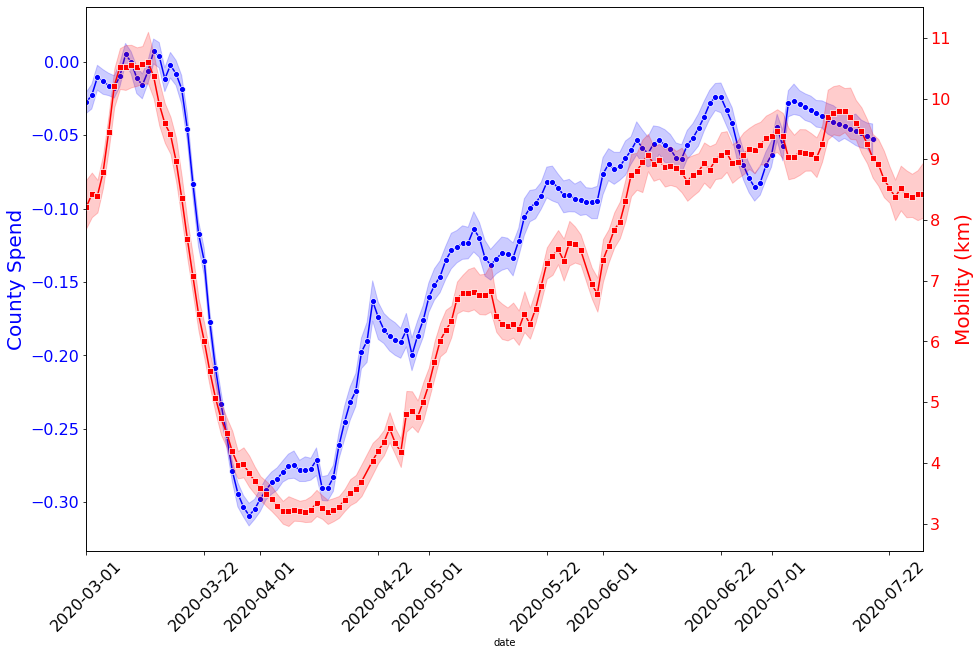

In [17]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x='date', y = 'spend_all', data=df_county_spending, marker='o',ci=100,color='blue')
plt.ylabel('County Spend', color='blue', fontsize=20)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16,color='blue')
ax2 = ax.twinx()
sns.lineplot(x='date', y = 'rolling_mean_mob', data=df_mobility_rm, marker='s',ci=100, ax =ax2, color = 'red')
plt.ylabel('Mobility (km)',color='red', fontsize=20)
plt.yticks(fontsize=16,color='red')
plt.xlim(df_mobility_rm.date.min(), df_mobility_rm.date.max())

In [18]:
def get_covid_rates():
    case_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Cases%20-%20County%20-%20Daily.csv?raw=true'
    death_url = 'https://github.com/OpportunityInsights/EconomicTracker/blob/main/data/COVID%20Deaths%20-%20County%20-%20Daily.csv?raw=true'
    df_covid_case_rate = pd.read_csv(case_url,low_memory=False)
    df_covid_death_rate = pd.read_csv(death_url,low_memory=False)
    df_covid_rate = pd.DataFrame()
    for df in [df_covid_case_rate,df_covid_death_rate]:
        df['date'] = df['year'].astype(str) + '-' + \
                            df['month'].astype(str) + '-' + \
                            df['day'].astype(str)
        df.date = pd.to_datetime(df.date, infer_datetime_format=True)
        df.countyfips = df.countyfips.astype(int)
        df.countyfips = df.countyfips.astype(str).str.zfill(5)
        df = df.rename(columns={'countyfips':'fips'})
        df = df.drop(columns=['month','day','year'])
        cols = list(df.columns[1:3])
        if 'death_rate' in cols:
            
            df = df.drop(columns=['fips','date'])
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)
        df_covid_rate = pd.concat([df_covid_rate,df], axis =1)
    return df_covid_rate
    

In [19]:
df_covid_rate = get_covid_rates()
df_covid_rate

,fips,case_rate,new_case_rate,date,death_rate,new_death_rate
0,01001,0.0,0.00,2020-01-21,0.00,0.000
1,01003,0.0,0.00,2020-01-21,0.00,0.000
2,01005,0.0,0.00,2020-01-21,0.00,0.000
3,01007,0.0,0.00,2020-01-21,0.00,0.000
4,01009,0.0,0.00,2020-01-21,0.00,0.000
...,...,...,...,...,...,...
600117,56037,553.0,11.10,2020-07-29,4.72,0.000
600118,56039,1355.0,51.10,2020-07-29,4.26,0.000
600119,56041,1211.0,14.80,2020-07-29,4.94,0.706
600120,56043,564.0,0.00,2020-07-29,64.10,0.000


In [22]:
df_covid = pd.merge(left = df_covid, right = df_covid_rate, on = ['fips', 'date'], how='outer')
df_mob_covid = pd.merge(left = df_mobility, right = df_covid, on = ['fips', 'date'], how='outer')
df_mob_covid['Weekday'] = df_mob_covid.date.dt.day_name()
df_mob_covid = df_mob_covid.dropna(subset=['Lat'])
fips_lat_lng = df_mob_covid[['fips','Lat','Lng']].drop_duplicates().set_index('fips').to_dict('index')
df_mob_covid

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend,Lat,...,Daily_deaths,case_rate_x,new_case_rate_x,death_rate_x,new_death_rate_x,case_rate_y,new_case_rate_y,death_rate_y,new_death_rate_y,Weekday
0,2020-03-01,Alabama,Autauga County,01001,1703.0,7.194,49.0,Sunday,Weekend,32.539527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sunday
1,2020-03-02,Alabama,Autauga County,01001,1829.0,14.587,100.0,Monday,Weekday,32.539527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday
2,2020-03-03,Alabama,Autauga County,01001,1840.0,13.865,95.0,Tuesday,Weekday,32.539527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tuesday
3,2020-03-04,Alabama,Autauga County,01001,1900.0,13.880,95.0,Wednesday,Weekday,32.539527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wednesday
4,2020-03-05,Alabama,Autauga County,01001,1825.0,14.659,100.0,Thursday,Weekday,32.539527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600265,2020-07-30,NaN,NaN,56037,NaN,NaN,NaN,NaN,NaN,41.659439,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
600266,2020-07-30,NaN,NaN,56039,NaN,NaN,NaN,NaN,NaN,43.935225,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
600267,2020-07-30,NaN,NaN,56041,NaN,NaN,NaN,NaN,NaN,41.287818,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
600268,2020-07-30,NaN,NaN,56043,NaN,NaN,NaN,NaN,NaN,43.904516,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday


In [26]:
# Get API keys from config file
def get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY):
    
    url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'
    query = '?q=' + str(lat) + ','+str(lng)
    key = '&key=' + API_KEY
    ret_format = '&format=json'
    sdate = '&enddate='+ start_dt
    edate = '&date=' + end_dt
    tp = '&tp=24'
    final_url = url + query + ret_format +  edate + sdate + tp + key
    get_weather = requests.get(final_url)
    weather_data = json.loads(get_weather.text)
   
    return weather_data

def get_weather_data(lat,lng, start_date,end_date,fips,key_count):
    new_low = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    new_end = datetime.timedelta(days=34) + new_low
    final_end = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    df = pd.DataFrame()
    API_KEYS = API_KEY_LIST
    last=False
    API_KEY=API_KEYS[key_count]
    if final_end-new_low <datetime.timedelta(days=34):
        weather_data = get_weather_chunk(lat,lng,start_date, end_date,API_KEY)
        df = pd.DataFrame(weather_data['data']['weather'])
        last = True
    while(last==False):
        if new_end <final_end:
            
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            while( 'error' in weather_data['data']):
                
                print('Error', API_KEY)
                    
            
                key_count+=1
                if key_count == len(API_KEYS):
                    raise Exception('Out of API Keys')
                API_KEY=API_KEYS[key_count]
                weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            new_low = new_end + datetime.timedelta(days=1)
            last_itr = new_end
            new_end = datetime.timedelta(days=34) + new_low

           
        else:
            new_low = last_itr + datetime.timedelta(days=1)
            new_end = final_end
            end_dt = datetime.datetime.strftime(new_low,'%Y-%m-%d' )
            start_dt = datetime.datetime.strftime(new_end,'%Y-%m-%d' )
            weather_data = get_weather_chunk(lat,lng,start_dt, end_dt,API_KEY)
            df_weather_chunk = pd.DataFrame(weather_data['data']['weather'])
            df = pd.concat([df,df_weather_chunk], ignore_index=True)
            last = True

    df = df.drop(columns=['uvIndex'])
    df_h = pd.DataFrame()
    
    for val in df['hourly'].values:
        df_h = pd.concat([df_h, pd.DataFrame(val)], ignore_index=True)
    
    df = pd.concat([df, df_h], axis=1)
    use_cols = ['date','tempC', 'maxtempC', 'mintempC','WindChillC','FeelsLikeC', 'visibilityMiles','HeatIndexC', 
            'avgtempC', 'windspeedMiles', 'winddirDegree','pressure', 'WindGustMiles','precipMM',
            'totalSnow_cm' , 'sunHour', 'DewPointC','humidity','uvIndex']
    df = df[use_cols]
    cols= [col for col in df.columns if col!='date']
    df= df.apply(pd.to_numeric, errors='ignore')
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['fips'] = fips
    return df,key_count

In [28]:
start_date = datetime.datetime.strftime(df_mob_covid.date.max(), '%Y-%m-%d')
end_date =  datetime.datetime.strftime(df_mob_covid.date.min(), '%Y-%m-%d')

fpath1 = './Data/Weather_Files/'
os.makedirs(fpath1, exist_ok=True)
files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
weather_files = [f for f in files_all if 'Weather' in f]
fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]
key_count = 0
for fips,lat_lng in list(fips_lat_lng.items()):
    if fips in fips_done:
        weather_df_fips = pd.read_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',parse_dates=['date'])
        if weather_df_fips.date.max() >= df_mob_covid.date.max():
            continue
        else:
            end_date = datetime.datetime.strftime(weather_df_fips.date.max()+datetime.timedelta(days=1),format='%Y-%m-%d') 
            start_date =datetime.datetime.strftime( df_mob_covid.date.max(),format='%Y-%m-%d') 
        
    
        
    lat,lng = lat_lng['Lat'],lat_lng['Lng']
    weather_df,key_count = get_weather_data(lat,lng, start_date,end_date,fips,key_count)
    weather_df = pd.concat([weather_df_fips,weather_df], ignore_index=True, axis=0)
    weather_df.to_csv(fpath1 + 'Weather_FIPS_'+str(fips)+'.csv',index=False)

In [30]:
def get_weather(start_date):
    fpath = './Data/All_County_Weather_'+start_date+'.csv'
    if os.path.exists(fpath):
        df_weather = pd.read_csv(fpath, parse_dates=['date'])
    else:
        fpath1 = './Data/Weather_Files/'
        files_all = [fpath1+f for f in listdir(fpath1) if isfile(join(fpath1, f))]
        weather_files = [f for f in files_all if 'Weather' in f]
        fips_done = [file.split('_')[3].split('.csv')[0] for file in weather_files]

        df_weather = pd.DataFrame()
        i=0
        for file in weather_files:
            df = pd.read_csv(file)
            df_weather = pd.concat([df_weather,df], ignore_index=True)
            i+=1
            if i%500 == 0:
                print('Finised Records = ', i)
        df_weather.date = pd.to_datetime(df_weather.date, infer_datetime_format=True)
        df_weather.to_csv('./Data/All_County_Weather_'+start_date+'.csv', index=False)
    df_weather.fips = df_weather.fips.astype(str).str.zfill(5)
    return df_weather
df_weather = get_weather(start_date)
df_weather

,date,tempC,maxtempC,mintempC,WindChillC,FeelsLikeC,visibilityMiles,HeatIndexC,avgtempC,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex,fips
0,2020-01-22,8,8,-2,0,0,6,3,4,5,105,1028,9,0.0,0.0,6.9,-8,49,1,01001
1,2020-01-23,8,8,2,3,3,3,5,5,8,96,1020,12,34.5,0.0,5.3,3,86,1,01001
2,2020-01-24,14,14,7,10,10,5,11,12,7,268,1016,11,17.2,0.0,10.0,8,82,4,01001
3,2020-01-25,11,11,2,4,4,6,6,7,6,293,1021,9,0.0,0.0,10.0,2,76,3,01001
4,2020-01-26,11,11,4,7,7,6,7,8,2,136,1020,4,0.1,0.0,6.9,4,78,2,01001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600117,2020-07-26,26,26,13,19,19,6,19,21,6,135,1017,10,1.5,0.0,11.4,9,56,5,56045
600118,2020-07-27,28,28,15,21,21,6,21,23,7,277,1016,11,0.5,0.0,14.5,6,40,6,56045
600119,2020-07-28,27,27,11,19,19,5,19,21,8,126,1010,13,12.9,0.0,12.4,9,55,5,56045
600120,2020-07-29,22,22,15,18,18,5,18,19,4,132,1012,8,11.5,0.0,9.2,12,71,4,56045


In [31]:
df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
df_mob_covid_weather

,date,STATE,COUNTY,fips,samples,m50,m50_index,weekday,weekend,Lat,...,windspeedMiles,winddirDegree,pressure,WindGustMiles,precipMM,totalSnow_cm,sunHour,DewPointC,humidity,uvIndex
0,2020-03-01,Alabama,Autauga County,01001,1703.0,7.194,49.0,Sunday,Weekend,32.539527,...,6,193,1023,10,0.0,0.0,11.3,6,68,4
1,2020-03-02,Alabama,Autauga County,01001,1829.0,14.587,100.0,Monday,Weekday,32.539527,...,7,188,1016,12,21.4,0.0,5.7,12,88,3
2,2020-03-03,Alabama,Autauga County,01001,1840.0,13.865,95.0,Tuesday,Weekday,32.539527,...,7,247,1012,12,24.5,0.0,5.7,17,93,4
3,2020-03-04,Alabama,Autauga County,01001,1900.0,13.880,95.0,Wednesday,Weekday,32.539527,...,9,28,1014,15,75.7,0.0,5.7,13,94,3
4,2020-03-05,Alabama,Autauga County,01001,1825.0,14.659,100.0,Thursday,Weekday,32.539527,...,10,143,1015,16,16.2,0.0,5.7,10,92,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600117,2020-07-30,NaN,NaN,56037,NaN,NaN,NaN,NaN,NaN,41.659439,...,6,277,1019,8,0.3,0.0,11.6,2,33,6
600118,2020-07-30,NaN,NaN,56039,NaN,NaN,NaN,NaN,NaN,43.935225,...,3,236,1020,5,0.0,0.0,11.6,6,56,5
600119,2020-07-30,NaN,NaN,56041,NaN,NaN,NaN,NaN,NaN,41.287818,...,5,207,1018,7,0.0,0.0,11.6,2,32,6
600120,2020-07-30,NaN,NaN,56043,NaN,NaN,NaN,NaN,NaN,43.904516,...,6,210,1019,9,0.0,0.0,14.5,9,40,7


In [32]:
df_county = pd.read_csv('./Data/nhgis0010_ds239_20185_2018_county.csv', encoding='latin')
df_county['fips'] = df_county.STATEA.astype(str).str.zfill(2)+df_county.COUNTYA.astype(str).str.zfill(3)
df_gini_income = pd.read_csv('./Data/nhgis0010_ds240_20185_2018_county.csv', encoding='latin')
df_gini_income = df_gini_income[['STATE', 'COUNTY', 'AKGVE001']]
df_county_demo = pd.merge(left = df_county , right = df_gini_income, on =['STATE', 'COUNTY'])
cols_A = df_county_demo.columns[df_county_demo.columns.str.endswith('A')]
margin_cols = [col for col in df_county_demo.columns if 'M' in col[4:5]]

df_county_demo = df_county_demo.drop(columns = ['GISJOIN']+list(cols_A) + margin_cols )
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,AJWBE001,AJWBE002,AJWBE003,AJWBE004,AJWBE005,AJWBE006,...,AJ35E060,AJ35E061,AJ35E062,AJ35E063,AJ35E064,AJ35E065,AJ35E066,NAME_M,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,1310,1387,455,0,32,2458,0,"Autauga County, Alabama",01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,7046,8078,1462,4,760,9752,162,"Baldwin County, Alabama",01003,0.4609


In [33]:
import re
f = open('./Data/nhgis0010_ds239_20185_2018_county_codebook.txt','r') 
searchlines = f.readlines()
f.close()
for i in range(len(searchlines)):
    if '    Margins of error' in searchlines[i] :
        error_margin = i
col_dict={}
for col in df_county_demo.columns[4:]:
    for i, line in enumerate(searchlines):
        #print(i)
        if col[:-4] in line and 'Table' in searchlines[i-3] and i <error_margin :
            text = re.sub(r"\s+", " ", searchlines[i-3].strip())
            top_col = text.split(':')[1].strip()
        if col in line:
            text = line.strip().split(':')[1:]
            col_name = ''.join(map(str, text))
            col_name = re.sub(r"\s+", " ", col_name).strip()
            #print(col_name)
            col_dict[col] = top_col+ '_' + col_name
        
df_county_demo = df_county_demo.rename(columns=col_dict)
insurance_cols = [col for col in df_county_demo.columns if 'Insurance' in col]
hispanic_cols = [col for col in df_county_demo.columns if 'Hispanic' in col]

df_county_demo = df_county_demo.drop(columns=insurance_cols+hispanic_cols)
df_county_demo.head(2)

,YEAR,STATE,COUNTY,NAME_E,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,fips,AKGVE001
0,2014-2018,Alabama,Autauga County,"Autauga County, Alabama",55200,26874,1789,2021,1754,1256,...,475.0,725.0,339.0,393.0,194.0,336.0,1509.0,718.0,01001,0.4602
1,2014-2018,Alabama,Baldwin County,"Baldwin County, Alabama",208107,101188,5855,5551,7544,4134,...,2390.0,2221.0,2183.0,1775.0,1516.0,1336.0,3961.0,2961.0,01003,0.4609


In [34]:
county_election = pd.read_csv('./Data/countypres_2000-2016.csv', sep = '\t')
county_election = county_election[county_election.year ==2016]
maj_party = county_election['party'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips = county_election['FIPS'][county_election.groupby('FIPS')['candidatevotes'].idxmax()]
fips_party = pd.concat([fips,maj_party], ignore_index=False,axis=1,).reset_index(drop=True).dropna()
fips_idx_county = county_election.set_index('FIPS')
pct_rep = (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes'])/ \
            (fips_idx_county[fips_idx_county['party']=='republican']['candidatevotes']+fips_idx_county[fips_idx_county['party']=='democrat']['candidatevotes'])
pct_rep = pct_rep.reset_index().rename(columns={'candidatevotes': 'pct_republican'})
fips_party = fips_party.join(pct_rep.set_index('FIPS'), on = 'FIPS')
fips_party.FIPS = fips_party.FIPS.astype(int).astype(str).str.zfill(5)
fips_party

,FIPS,party,pct_republican
0,01001,republican,0.753775
1,01003,republican,0.797922
2,01005,republican,0.528232
3,01007,republican,0.782397
4,01009,republican,0.913812
...,...,...,...
3150,56037,republican,0.789990
3151,56039,democrat,0.348999
3152,56041,republican,0.836596
3153,56043,republican,0.845484


In [35]:
total_cols = [col for col in df_county_demo.columns if 'Total' in col]
for col in total_cols:
    remaining_cols = [c for c in list(df_county_demo.columns) if c!=col]
    for df_col in remaining_cols:
        if col.split('_')[0] in df_col:
            df_county_demo[df_col] = df_county_demo[df_col]/df_county_demo[col]
df_county_demo = df_county_demo.join(fips_party.set_index('FIPS'), on = 'fips')  
df_county_demo.isna().sum()

YEAR                                                                                   0
STATE                                                                                  0
COUNTY                                                                                 0
NAME_E                                                                                 0
Sex by Age_Total                                                                       0
                                                                                    ... 
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed      1
fips                                                                                   0
AKGVE001                                                                               1
party                                                                                106
pct_republican                                                                       106
Length: 150, dtype: i

In [36]:
df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['STATE', 'COUNTY']), right = df_county_demo, on = ['fips'])
# Removing the dates before March 1 for mobility predictions
df_all_mob = df_all[(df_all.date >= df_mobility.date.min()) 
                                            & (df_all.date <= df_mobility.date.max())]

#Eventual Test data for which we do not have mobility values
df_mob_null = df_all_mob.mask(df_all_mob.isnull())
# Defining the training dataset
df_mob_train = df_all_mob.dropna()
df_mob_train

,date,fips,samples,m50,m50_index,weekday,weekend,Lat,Lng,Total_cases,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001,party,pct_republican
0,2020-03-01,01001,1703.0,7.194,49.0,Sunday,Weekend,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
1,2020-03-02,01001,1829.0,14.587,100.0,Monday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
2,2020-03-03,01001,1840.0,13.865,95.0,Tuesday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
3,2020-03-04,01001,1900.0,13.880,95.0,Wednesday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
4,2020-03-05,01001,1825.0,14.659,100.0,Thursday,Weekday,32.539527,-86.644082,0.0,...,0.136767,0.063950,0.074137,0.036597,0.063384,0.284663,0.135446,0.4602,republican,0.753775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509540,2020-07-24,56041,772.0,7.377,235.0,Friday,Weekday,41.287818,-110.547578,232.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
509541,2020-07-25,56041,779.0,15.178,484.0,Saturday,Weekend,41.287818,-110.547578,232.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
509542,2020-07-26,56041,839.0,33.783,1078.0,Sunday,Weekend,41.287818,-110.547578,233.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596
509543,2020-07-27,56041,689.0,7.134,227.0,Monday,Weekday,41.287818,-110.547578,235.0,...,0.167277,0.091479,0.099320,0.055410,0.061683,0.124412,0.077365,0.4002,republican,0.836596


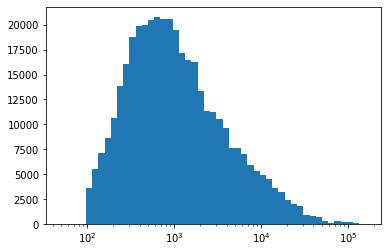

In [37]:
data = df_mobility['samples']
plt.hist(data, bins=np.logspace(np.log10(50),np.log10(df_mobility['samples'].max()), 50))
plt.xscale("log")

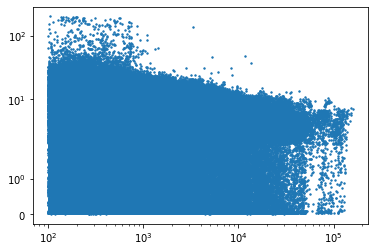

In [38]:
plt.scatter(df_mobility['samples'],df_mobility['m50'],s=2)
plt.xscale('log')
plt.yscale('symlog')

In [49]:
def run_model(df,name,task_type='GPU',max_depth= 6):
    remove_cols = ['date','fips', 'samples','COUNTY','m50_index', 'Lat', 'Lng','YEAR','NAME_E' ]
    target_var = ['m50']
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var + ['weekday'])
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("Weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth, learning_rate=0.3,verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 5.5117471	total: 57.1ms	remaining: 57s
200:	learn: 1.9094517	total: 9.4s	remaining: 37.4s
400:	learn: 1.5173930	total: 19.2s	remaining: 28.8s
600:	learn: 1.2791474	total: 28.8s	remaining: 19.1s
800:	learn: 1.1176213	total: 38.7s	remaining: 9.63s
999:	learn: 0.9829978	total: 48.5s	remaining: 0us
0.86


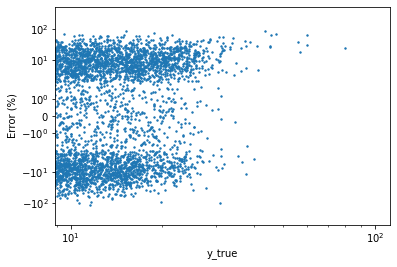

,Pre_Covid_Feature_Importance
Travel Time to Work_10 to 14 minutes,8.653994
Weekday,6.936601
STATE,6.659394
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,4.499349
Travel Time to Work_5 to 9 minutes,3.121767
Travel Time to Work_15 to 19 minutes,2.683014
Race_White alone,2.638128
Race_Asian alone,2.473392
FeelsLikeC,2.285423
Means of Transportation to Work_Walked,2.052211


In [73]:
df_mob_train_pre = df_mob_train[df_mob_train.date < '2020-03-15']
df_mob_train_pre = df_mob_train_pre[df_mob_train_pre.m50<100]
df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,name = 'Pre', task_type='CPU',max_depth = 6)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:25]

In [66]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test['error_pct'].hist(bins=100)
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)


<ipython-input-66-8bbe20f28b29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = y_pred_cb
<ipython-input-66-8bbe20f28b29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50


,error_pct,Count
STATE,,
Alabama,0.227967,176
Alaska,-41.669883,3
Arizona,7.485430,46
Arkansas,-1.732755,200
California,2.344989,149
Colorado,-1.316314,127
Connecticut,4.914620,25
Delaware,4.584038,10
Florida,-1.083806,195


0:	learn: 4.7196991	total: 77.3ms	remaining: 1m 17s
200:	learn: 1.9700825	total: 11.7s	remaining: 46.3s
400:	learn: 1.7378430	total: 22.9s	remaining: 34.2s
600:	learn: 1.5958518	total: 34.4s	remaining: 22.9s
800:	learn: 1.4866559	total: 46.2s	remaining: 11.5s
999:	learn: 1.4038472	total: 57.7s	remaining: 0us
0.85


<ipython-input-49-6e2a27272643>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)


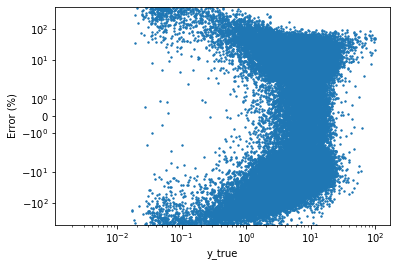

,Post_Covid_Feature_Importance
Weekday,7.459024
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,6.271460
Travel Time to Work_10 to 14 minutes,5.641013
STATE,4.914942
case_rate_x,3.863875
sunHour,3.127226
pct_republican,2.793036
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,2.441844
maxtempC,2.310568
Travel Time to Work_5 to 9 minutes,2.031062


In [55]:
df_mob_train_covid = df_mob_train[df_mob_train.date >= '2020-03-15']
df_mob_train_covid = df_mob_train_covid[df_mob_train_covid.m50<100]
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,name='Post',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

In [56]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], axis=1)

<ipython-input-56-56861c4dcd50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = y_pred_cb
<ipython-input-56-56861c4dcd50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['error_pct'] = (y_test.m50 - y_test.pred)*100/y_test.m50


,error_pct,Count
STATE,,
Alabama,-0.116798,1792
Alaska,-0.790825,28
Arizona,0.818497,399
Arkansas,-0.609859,1904
California,0.168623,1447
Colorado,0.914615,1154
Connecticut,-0.412214,228
Delaware,-1.188216,73
Florida,2.157103,1775


In [61]:
name_dict = df_county_demo.set_index('fips')['NAME_E'].to_dict()
def get_name(name_dict, x):
    if x in name_dict.keys():
        return name_dict[x]
    else:
        return None
df_mobility_rm['name'] = df_mobility_rm['fips'].apply(lambda x: get_name(name_dict, x))
df_mobility_rm[df_mobility_rm['m50']>100]

,fips,date,m50,rolling_mean_mob,name
11842,04012,2020-05-25,100.212,25.632429,"La Paz County, Arizona"
11861,04012,2020-06-14,105.177,30.187429,"La Paz County, Arizona"
35097,08073,2020-03-14,114.821,51.002429,"Lincoln County, Colorado"
35164,08073,2020-05-21,105.382,46.096286,"Lincoln County, Colorado"
35202,08073,2020-06-29,101.598,71.106286,"Lincoln County, Colorado"
...,...,...,...,...,...
389622,56007,2020-06-27,132.281,79.808000,"Carbon County, Wyoming"
389623,56007,2020-06-28,160.607,83.169429,"Carbon County, Wyoming"
389637,56007,2020-07-12,121.325,60.085429,"Carbon County, Wyoming"
389643,56007,2020-07-18,139.715,69.538143,"Carbon County, Wyoming"


# Mobility Reduction

In [22]:
# Creating a dataframe to record reduction in spending and mobility before and after covid
target_cols = ['rolling_mean_mob','spend_all']
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
window = covid_date -datetime.timedelta(days=10)
df_covid = df_merged[df_merged.date>=window]
df_pre = df_merged[(df_merged.date<window)]
df_pre_mean = df_pre.groupby(['fips','date'])[target_cols].mean()

pre_covid_mean = df_pre_mean.groupby(level=[0])[target_cols].mean()
df_covid_mean = df_covid.groupby(['fips','date'])[target_cols].mean()


post_covid_min_date = df_covid_mean.groupby(level=[0])[target_cols].idxmin()
for col in target_cols:
    rename_col = 'min_date_' + col
    post_covid_min_date['min_date_'+col] = post_covid_min_date[col].str[1]
    post_covid_min_date = post_covid_min_date.drop(columns=[col])
post_covid_min = y.groupby(level=[0])[target_cols].min()
for col in target_cols:
    post_covid_min = post_covid_min.rename(columns={col:'Min_'+col})
df_mob_spend_red = pd.concat([pre_covid_mean,post_covid_min,post_covid_min_date],axis=1)

df_mob_spend_red = df_mob_spend_red.reset_index()
df_mob_spend_red = df_mob_spend_red.rename(columns={'index':'fips'})
for col in target_cols:
    min_date_col = 'min_date_' + col
    
    df_mob_spend_red['Drop_days_'+col] = (df_mob_spend_red[min_date_col] - covid_date).dt.days
    if col!='spend_all':
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((df_mob_spend_red[col] -df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])/df_mob_spend_red[col]
        df_mob_spend_red['Pct_Red_'+col] =( df_mob_spend_red[col] - df_mob_spend_red['Min_'+col])/df_mob_spend_red[col]
    else:
        df_mob_spend_red['Norm_Drop_Rate_'+col] = ((-1*df_mob_spend_red['Min_'+col])/df_mob_spend_red['Drop_days_'+col])
        df_mob_spend_red['Pct_Red_'+col] = -1*df_mob_spend_red['Min_'+col]
df_mob_spend_red = df_mob_spend_red[df_mob_spend_red['Pct_Red_rolling_mean_mob']>=-0.5]
df_mob_spend_red.sample(5)

,fips,rolling_mean_mob,spend_all,Min_rolling_mean_mob,Min_spend_all,min_date_rolling_mean_mob,min_date_spend_all,Drop_days_rolling_mean_mob,Norm_Drop_Rate_rolling_mean_mob,Pct_Red_rolling_mean_mob,Drop_days_spend_all,Norm_Drop_Rate_spend_all,Pct_Red_spend_all
581,17117,8.280643,-0.039400,1.800571,-0.318,2020-03-28,2020-03-28,13.0,0.060197,0.782557,13.0,0.024462,0.318
60,01121,17.630429,-0.032879,4.720857,-0.236,2020-04-12,2020-03-29,28.0,0.026151,0.732232,14.0,0.016857,0.236
284,12023,6.964750,-0.032875,3.889286,-0.273,2020-04-19,2020-03-30,35.0,0.012616,0.441576,15.0,0.018200,0.273
89,04025,3.376964,0.015122,0.752714,-0.314,2020-04-13,2020-04-13,29.0,0.026797,0.777103,29.0,0.010828,0.314
326,12107,8.237857,-0.032957,3.531143,-0.194,2020-04-10,2020-03-29,26.0,0.021975,0.571352,14.0,0.013857,0.194


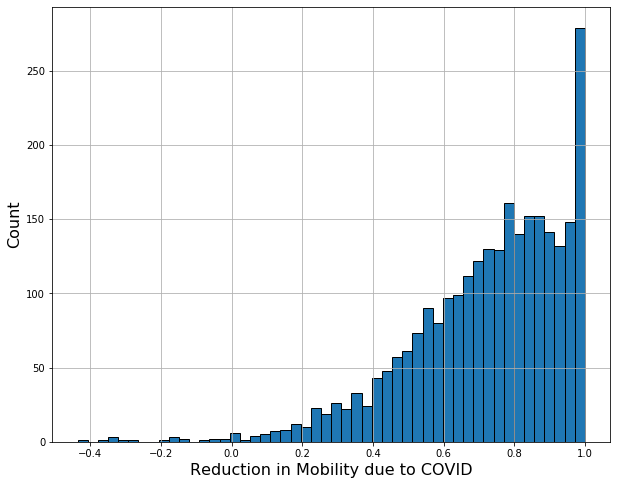

In [21]:
plt.figure(figsize=(10,8))
plt.rcParams["patch.force_edgecolor"] = True

df_mob_spend_red['Pct_Red_rolling_mean_mob'].hist(bins = 50)
plt.xlabel('Reduction in Mobility due to COVID', fontsize=16)
plt.ylabel('Count', fontsize = 16)
df_mob_spend_red['loc'] = df_mob_spend_red['fips'].apply(lambda x: get_county_state(county_dict,x))

In [47]:
df_mobility_index

,date,STATE,COUNTY,fips,samples,m50,m50_index
136,2020-03-01,Alabama,Autauga County,01001,1703,7.194,49
137,2020-03-02,Alabama,Autauga County,01001,1829,14.587,100
138,2020-03-03,Alabama,Autauga County,01001,1840,13.865,95
139,2020-03-04,Alabama,Autauga County,01001,1900,13.880,95
140,2020-03-05,Alabama,Autauga County,01001,1825,14.659,100
...,...,...,...,...,...,...,...
367134,2020-07-12,Wyoming,Uinta County,56041,756,24.010,766
367135,2020-07-13,Wyoming,Uinta County,56041,732,5.584,178
367136,2020-07-14,Wyoming,Uinta County,56041,651,5.035,160
367137,2020-07-15,Wyoming,Uinta County,56041,700,6.373,203


In [48]:
df_merged = pd.merge(left = df_mobility_index, right = df_covid_growth, on= ['COUNTY', 'STATE'],how='left')
df_merged['growthFactor'] = df_merged['growthFactor'].fillna(df_merged['growthFactor'].mean() )
df_merged.corr()

,samples,m50,m50_index,growthFactor
samples,1.000000,-0.069507,-0.045263,0.077986
m50,-0.069507,1.000000,0.279804,-0.014436
m50_index,-0.045263,0.279804,1.000000,-0.020126
growthFactor,0.077986,-0.014436,-0.020126,1.000000


In [165]:
X_train

,STATE,Drop_days,growthFactor,Sex by Age_Total,Sex by Age_Male,Sex by Age_Male Under 5 years,Sex by Age_Male 5 to 9 years,Sex by Age_Male 10 to 14 years,Sex by Age_Male 15 to 17 years,Sex by Age_Male 18 and 19 years,...,Gross Rent as a Percentage of Household Income in the Past 12 Months_10.0 to 14.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_15.0 to 19.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_25.0 to 29.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_30.0 to 34.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_35.0 to 39.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_40.0 to 49.9 percent,Gross Rent as a Percentage of Household Income in the Past 12 Months_50.0 percent or more,Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,AKGVE001
2205,Kentucky,17,1.024478,8637,0.490680,0.028019,0.029293,0.034850,0.022577,0.017483,...,0.187852,0.077615,0.057368,0.039370,0.042745,0.109111,0.075366,0.146232,0.209224,0.4569
940,North Carolina,29,1.062903,130361,0.495348,0.038877,0.038171,0.038762,0.021072,0.013578,...,0.083765,0.129864,0.119495,0.112499,0.080705,0.049097,0.105628,0.185833,0.108189,0.4177
1815,Iowa,31,1.077123,25039,0.490754,0.029115,0.036303,0.039179,0.021606,0.013140,...,0.168367,0.131725,0.115955,0.114100,0.040816,0.038961,0.059369,0.103432,0.140538,0.3995
219,New York,30,1.027273,194402,0.491806,0.027093,0.029166,0.026363,0.018379,0.022273,...,0.089669,0.098801,0.091979,0.096784,0.072138,0.063300,0.071955,0.285070,0.082297,0.4591
445,North Carolina,22,1.023947,10813,0.473967,0.017294,0.031629,0.027189,0.009711,0.006936,...,0.117647,0.067109,0.167357,0.128418,0.019056,0.064623,0.004143,0.176471,0.226181,0.4871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Georgia,25,1.070217,106497,0.475112,0.033747,0.039738,0.037316,0.025926,0.016498,...,0.075733,0.112078,0.094159,0.106584,0.081819,0.061702,0.090102,0.272082,0.057561,0.4384
1095,Idaho,17,1.010000,27969,0.511102,0.049233,0.051092,0.047088,0.030069,0.016483,...,0.129693,0.104664,0.233788,0.030717,0.035267,0.034130,0.036974,0.090444,0.153584,0.3723
1130,Kentucky,22,1.017534,22843,0.490303,0.031738,0.037473,0.024778,0.019700,0.010725,...,0.059140,0.069479,0.048801,0.102151,0.094706,0.083954,0.047560,0.188172,0.250620,0.4966
1294,New York,38,0.859362,26719,0.503425,0.029941,0.032000,0.034657,0.019574,0.010517,...,0.087283,0.089629,0.076959,0.083998,0.092445,0.054435,0.063820,0.265603,0.111685,0.4126


In [194]:
import shap

from catboost import Pool
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=10)
shap_values = cb_model.get_feature_importance(Pool(X_train, label=y_train),
                                               fstr_type="ShapValues",shap_calc_type='Approximate')
shap_values = shap_values[:, :-1]

title = "SHAP Value - CatBoost:COVID"
plt.title(title)
shap.summary_plot(shap_values, X_train, show=True)

TypeError: an integer is required (got type bytes)

In [46]:
top10_pop = df_all.groupby(['STATE'])['Sex by Age_Total'].mean().sort_values(ascending=False).index[:10]

def filter_df(x):
    if x in top10_pop:
        return x
    else:
        return None
df_all_fil = df_all.copy()

df_all_fil['STATE'] = df_all_fil['STATE'].apply(lambda x: filter_df(x))
df_all_fil = df_all_fil.dropna()


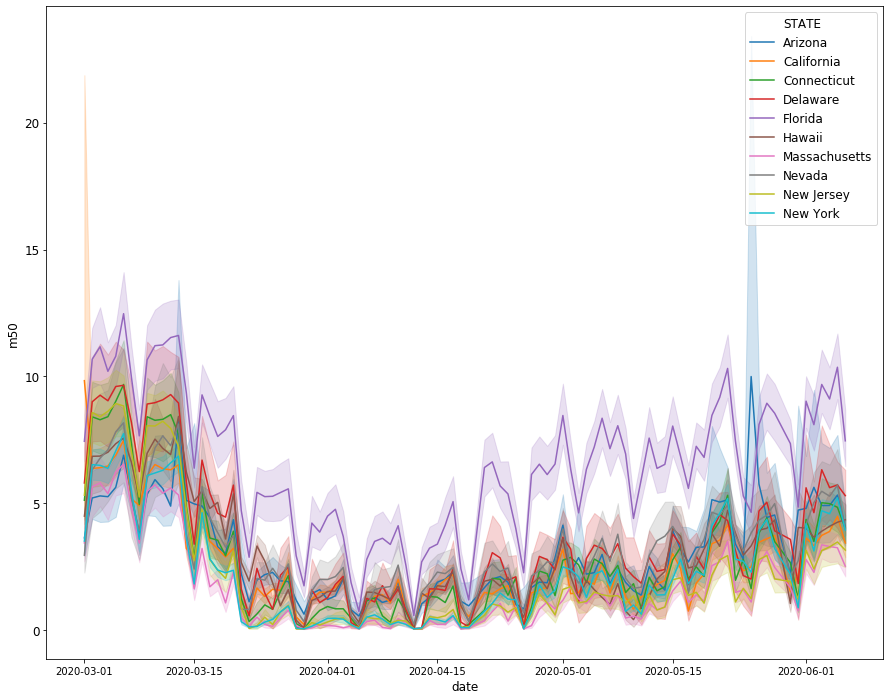

In [47]:
plt.figure(figsize=(15,12))
sns.lineplot(x='date', y = 'm50', hue='STATE', data=df_all_fil)